In [4]:
from bivariate import *
import numpy as np
import matplotlib.pyplot as plt

In [116]:
def gradient_hessian_u(x, mu, sigma, grad_only=False):
    """
    Compute gradient of U for bivariate Gaussian.
    mu: the mean vector (length 2)
    sigma: the 2x2 covariance matrix
    """
    # grads
    sigma1_square, rho_sigma1_sigma2, _, sigma2_square = sigma.flatten()
    simga1_sigma2 = np.sqrt(sigma1_square * sigma2_square)
    rho = rho_sigma1_sigma2 / simga1_sigma2
    rho_inv = 1 / (1 - rho ** 2)

    grad_1 = ((x[0] - mu[0]) / sigma1_square) - (rho * (x[1] - mu[1]) / simga1_sigma2)
    grad_2 = ((x[1] - mu[1]) / sigma2_square) - (rho * (x[0] - mu[0]) / simga1_sigma2)

    if grad_only:
        return rho_inv * np.array([grad_1, grad_2])

    # hessian
    hessian = np.array([[1 / sigma1_square, -rho / simga1_sigma2], [-rho / simga1_sigma2, 1 / sigma2_square]])

    return rho_inv * np.array([grad_1, grad_2]), rho_inv * hessian

In [200]:
def adaptive_langevin_dynamics(mu, sigma, steps, dt, alpha, verbose=False, mala=True):
    """Simulate Langevin dynamics for bivariate Gaussian."""
    X = np.zeros((steps, 2))
    q_coefs, d_coefs = [-5], [np.ones(2)]
    current_log_like = log_likelihood(X[0], mu, sigma)
    success = 0

    _, hessian_u = gradient_hessian_u(X[0], mu, sigma)

    for t in range(1, steps):
        grad_u = gradient_hessian_u(X[t - 1], mu, sigma, grad_only=True)
        # set up the diffusion matrix
        Q = np.array([[0, q_coefs[-1]], [-q_coefs[-1], 0]])
        proposed_X = X[t - 1] - (grad_u + Q @ grad_u) * dt + np.sqrt(2 * dt) * np.random.randn(2)

        # MALA step
        if mala:
            proposed_log_like = log_likelihood(proposed_X, mu, sigma)
            forward_log_proposal = log_proposal(proposed_X, X[t - 1], grad_u, dt, Q)
            backward_grad = gradient_hessian_u(proposed_X, mu, sigma, grad_only=True)
            backward_log_proposal = \
                log_proposal(X[t - 1], proposed_X, backward_grad, dt, Q)

            log_accept_ratio = proposed_log_like + backward_log_proposal - current_log_like - forward_log_proposal

        if not mala or np.log(np.random.rand()) < log_accept_ratio:
            X[t] = proposed_X
            if mala:
                current_log_like = proposed_log_like
            success += 1

            # update the cofficients (adaptive part)
            # d_coefs is of size 2
            dq = grad_u @ d_coefs[-1]
            q = q_coefs[-1] - alpha * dq
            # q = np.clip(q, 0, 10)
            dd = ((np.eye(2) + Q) @ hessian_u @ d_coefs[-1]) + np.array([[0, 1], [-1, 0]]) @ grad_u
            d = d_coefs[-1] - dt * dd

            if verbose:
                print({
                    "prev_x": X[t-1],
                    "dq": dq,
                    "dd": dd,
                    "grad_u": grad_u,
                    "hessian_u": hessian_u
                })

            q_coefs.append(q)
            d_coefs.append(d)
        else:
            X[t] = X[t - 1]
            q_coefs.append(q_coefs[-1])
            d_coefs.append(d_coefs[-1])

    return X, q_coefs, d_coefs, success

In [201]:
mu = np.array([0, 0])
sigma = np.array([[1, 0.5], [0.5, 1]])
steps = 100000
dt = 1e-2
alpha = 1e-3

X, q_coefs, d_coefs, success = adaptive_langevin_dynamics(mu, sigma, steps, dt, alpha, verbose=False, mala=False)

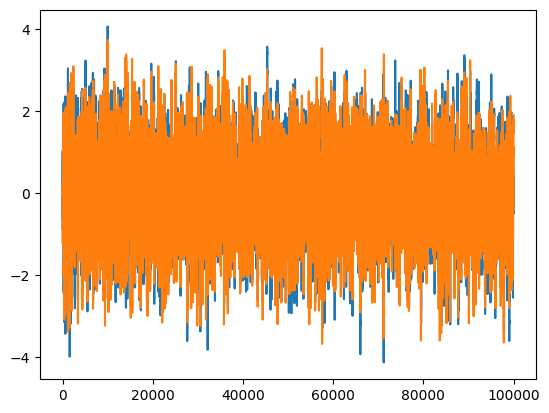

In [202]:
plt.plot(X)

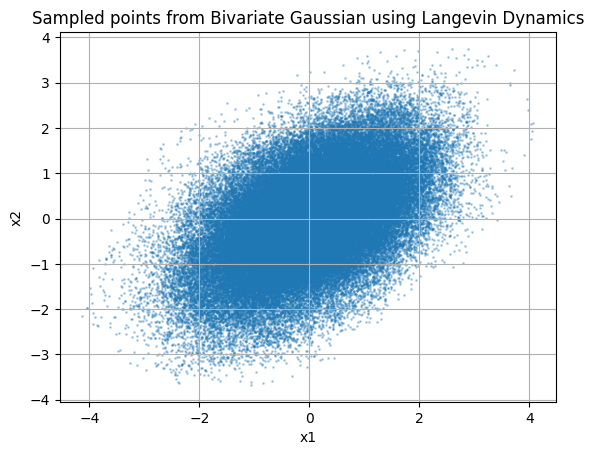

In [206]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.3, s=1)
plt.title('Sampled points from Bivariate Gaussian using Langevin Dynamics')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

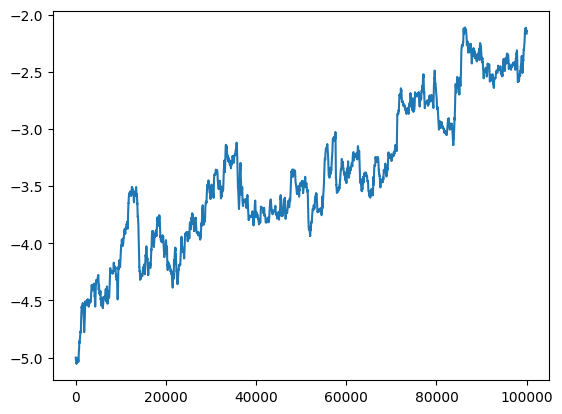

In [204]:
plt.plot(q_coefs)

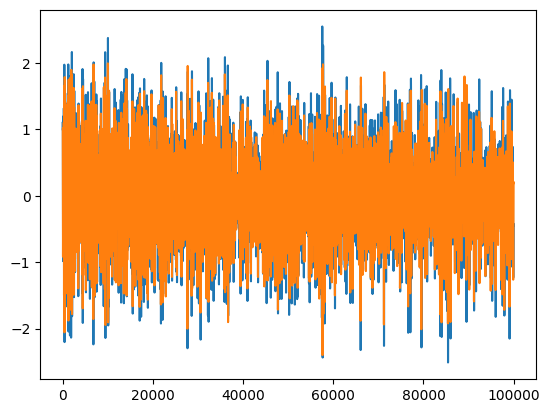

In [205]:
plt.plot(d_coefs)

In [141]:
d_coefs

[array([0., 0.]),
 array([0., 0.]),
 array([-0.02204941, -0.00163226]),
 array([-0.12651607, -0.01570231]),
 array([-0.14918857, -0.02212273]),
 array([-0.17714227,  0.0028768 ]),
 array([-0.29272766, -0.03356872]),
 array([-0.5235827 , -0.19661693]),
 array([-0.6868927 , -0.37648501]),
 array([-0.91344649, -0.71424902]),
 array([-1.04268503, -0.92951583]),
 array([-1.15781627, -1.12779272]),
 array([-1.17196736, -1.23421082]),
 array([-1.150027  , -1.33890332]),
 array([-1.11079542, -1.36151742]),
 array([-1.10770058, -1.47447382]),
 array([-1.01009326, -1.44323986]),
 array([-1.02110747, -1.47447963]),
 array([-0.87560076, -1.41575273]),
 array([-0.59925107, -1.25913246]),
 array([-0.32537045, -1.03368816]),
 array([-0.16594093, -0.86981524]),
 array([ 0.07981688, -0.55569038]),
 array([ 0.39742629, -0.10179919]),
 array([0.62069532, 0.34398945]),
 array([0.68295876, 0.71337817]),
 array([0.64311608, 0.99876454]),
 array([0.54775034, 1.18497803]),
 array([0.38815123, 1.23957422]),
 a